# Economic Data Analysis with Fred & Pandas


In [24]:
!pip3 install fredapi > /dev/null
!pip3 install plotly_express

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)

color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = 'cea00c39d59d1a070a2daad7a40e28bb'

# # from kaggle_secrets import UserSecretsClient
# secrets = UserSecretsClient()
# fred_key = secrets.get_secret('fred-api')

# 1. Create The Fred Object

In [26]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data!

In [27]:
sp_search = fred.search('S&P', order_by='popularity')

In [28]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2025-07-07,2025-07-07,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2025-07-04,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-07-07 07:44:05-05:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2025-07-07,2025-07-07,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2025-04-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2025-06-24 08:12:56-05:00,88,"For more information regarding the index, plea..."
SP500,SP500,2025-07-07,2025-07-07,S&P 500,2015-07-06,2025-07-03,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2025-07-03 19:04:07-05:00,83,The observations for the S&P 500 represent the...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2025-07-07,2025-07-07,ICE BofA US High Yield Index Effective Yield,1996-12-31,2025-07-04,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-07-07 07:44:08-05:00,82,This data represents the effective yield of th...
BAMLC0A0CM,BAMLC0A0CM,2025-07-07,2025-07-07,ICE BofA US Corporate Index Option-Adjusted Sp...,1996-12-31,2025-07-04,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-07-07 07:51:02-05:00,78,The ICE BofA Option-Adjusted Spreads (OASs) ar...


# 3. Pull Raw Data & Plot

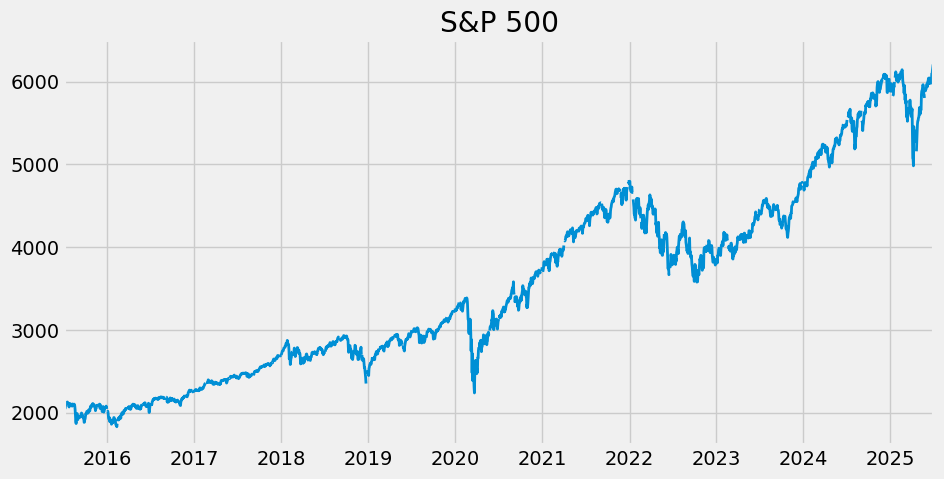

In [29]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

# 4. Pull and Join Multiple Data Series

In [30]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]
print(unemp_df.shape)
print(unemp_df.index)


(46, 15)
Index(['UNRATE', 'LNS14000006', 'CAUR', 'TXUR', 'M0892AUSM156SNBR',
       'LNS14000024', 'LNS14000031', 'M0892BUSM156SNBR', 'NYUR', 'U2RATE',
       'FLUR', 'LNS14000002', 'LNS14000009', 'LNS14000003', 'PAUR', 'OHUR',
       'LNS14000001', 'LNS14027660', 'MIUR', 'LNS14027662', 'ALUR',
       'LNS14024887', 'MAUR', 'NCUR', 'ILUR', 'NJUR', 'GAUR', 'COUR', 'AZUR',
       'WIUR', 'VAUR', 'KYUR', 'LRUN64TTUSM156S', 'SCUR', 'NMUR', 'MNUR',
       'TNUR', 'LNS14032183', 'LNS14000012', 'WAUR', 'LNS14027659', 'MDUR',
       'ORUR', 'WVUR', 'NVUR', 'ARUR'],
      dtype='object', name='series id')


In [ ]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
print(all_results.shape)
uemp_results = pd.concat(all_results, axis=1)
print(uemp_results.shape)

[            UNRATE
1948-01-01     3.4
1948-02-01     3.8
1948-03-01     4.0
1948-04-01     3.9
1948-05-01     3.5
...            ...
2025-02-01     4.1
2025-03-01     4.2
2025-04-01     4.2
2025-05-01     4.2
2025-06-01     4.1

[930 rows x 1 columns],             LNS14000006
1972-01-01         11.2
1972-02-01         11.2
1972-03-01         10.7
1972-04-01          9.8
1972-05-01         10.2
...                 ...
2025-02-01          6.0
2025-03-01          6.2
2025-04-01          6.3
2025-05-01          6.0
2025-06-01          6.8

[642 rows x 1 columns],             CAUR
1976-01-01   9.2
1976-02-01   9.2
1976-03-01   9.1
1976-04-01   9.0
1976-05-01   8.9
...          ...
2025-01-01   5.4
2025-02-01   5.4
2025-03-01   5.3
2025-04-01   5.3
2025-05-01   5.3

[593 rows x 1 columns],             TXUR
1976-01-01   5.8
1976-02-01   5.8
1976-03-01   5.9
1976-04-01   5.9
1976-05-01   6.0
...          ...
2025-01-01   4.1
2025-02-01   4.1
2025-03-01   4.1
2025-04-01   4.1
2025-05-01   4.1


In [51]:
print(all_results)
print(uemp_results.shape)

[            UNRATE
1948-01-01     3.4
1948-02-01     3.8
1948-03-01     4.0
1948-04-01     3.9
1948-05-01     3.5
...            ...
2025-02-01     4.1
2025-03-01     4.2
2025-04-01     4.2
2025-05-01     4.2
2025-06-01     4.1

[930 rows x 1 columns],             LNS14000006
1972-01-01         11.2
1972-02-01         11.2
1972-03-01         10.7
1972-04-01          9.8
1972-05-01         10.2
...                 ...
2025-02-01          6.0
2025-03-01          6.2
2025-04-01          6.3
2025-05-01          6.0
2025-06-01          6.8

[642 rows x 1 columns],             CAUR
1976-01-01   9.2
1976-02-01   9.2
1976-03-01   9.1
1976-04-01   9.0
1976-05-01   8.9
...          ...
2025-01-01   5.4
2025-02-01   5.4
2025-03-01   5.3
2025-04-01   5.3
2025-05-01   5.3

[593 rows x 1 columns],             TXUR
1976-01-01   5.8
1976-02-01   5.8
1976-03-01   5.9
1976-04-01   5.9
1976-05-01   6.0
...          ...
2025-01-01   4.1
2025-02-01   4.1
2025-03-01   4.1
2025-04-01   4.1
2025-05-01   4.1


In [57]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)
print(uemp_results.shape)

(1143, 28)


In [54]:
print(uemp_results)

            CAUR  TXUR  NYUR  FLUR  PAUR  OHUR  MIUR  ALUR  MAUR  NCUR  ILUR  \
1929-04-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1929-05-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1929-06-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1929-07-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1929-08-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2025-02-01   5.4   4.1   4.3   3.6   3.8   4.7   5.4   3.3   4.3   3.7   4.8   
2025-03-01   5.3   4.1   4.2   3.6   3.8   4.8   5.5   3.3   4.4   3.7   4.8   
2025-04-01   5.3   4.1   4.2   3.7   3.9   4.9   5.5   3.3   4.6   3.7   4.8   
2025-05-01   5.3   4.1   4.0   3.7   3.9   4.9   5.4   3.3   4.8   3.7   4.8   
2025-06-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            NJUR  GAUR  COUR  AZUR  WIU

In [33]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [34]:
# Plot States Unemployment Rate
px.line(uemp_states)

# Pull April 2020 Unemployment Rate Per State

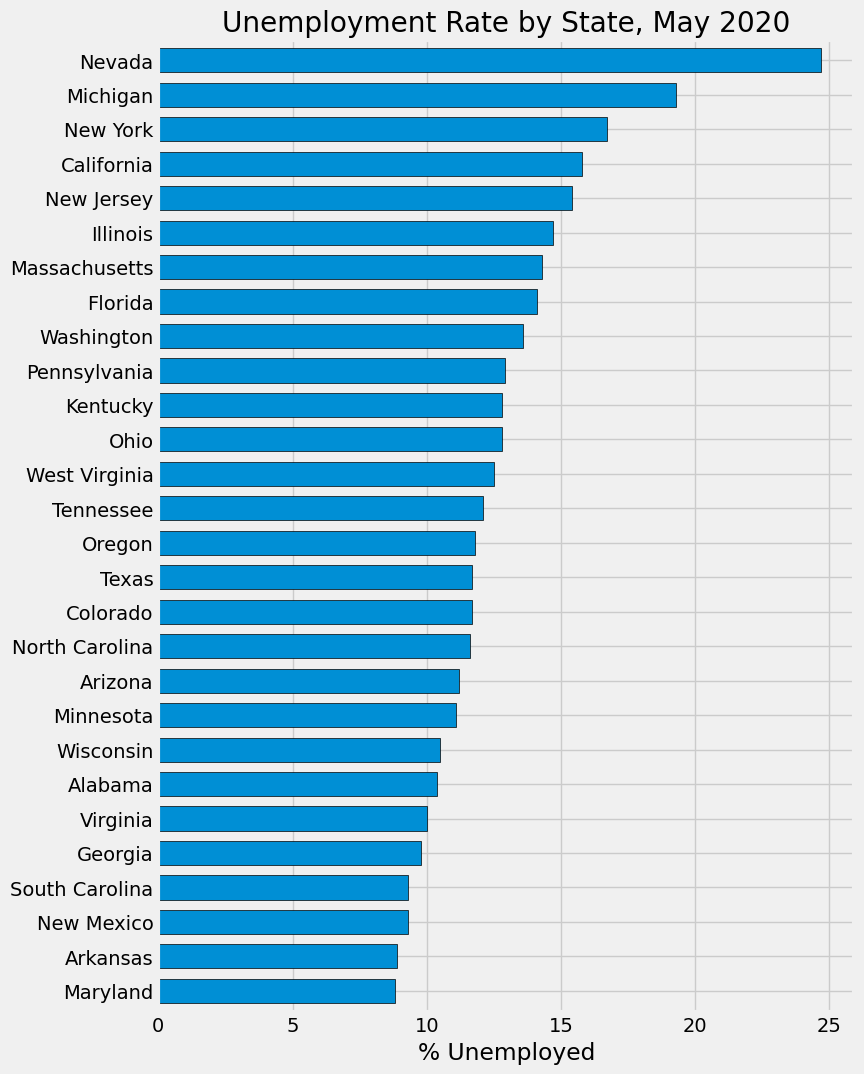

In [35]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

# Pull Participation Rate

In [36]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [37]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

# Plot Unemployment vs Participation for each state!

In [38]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

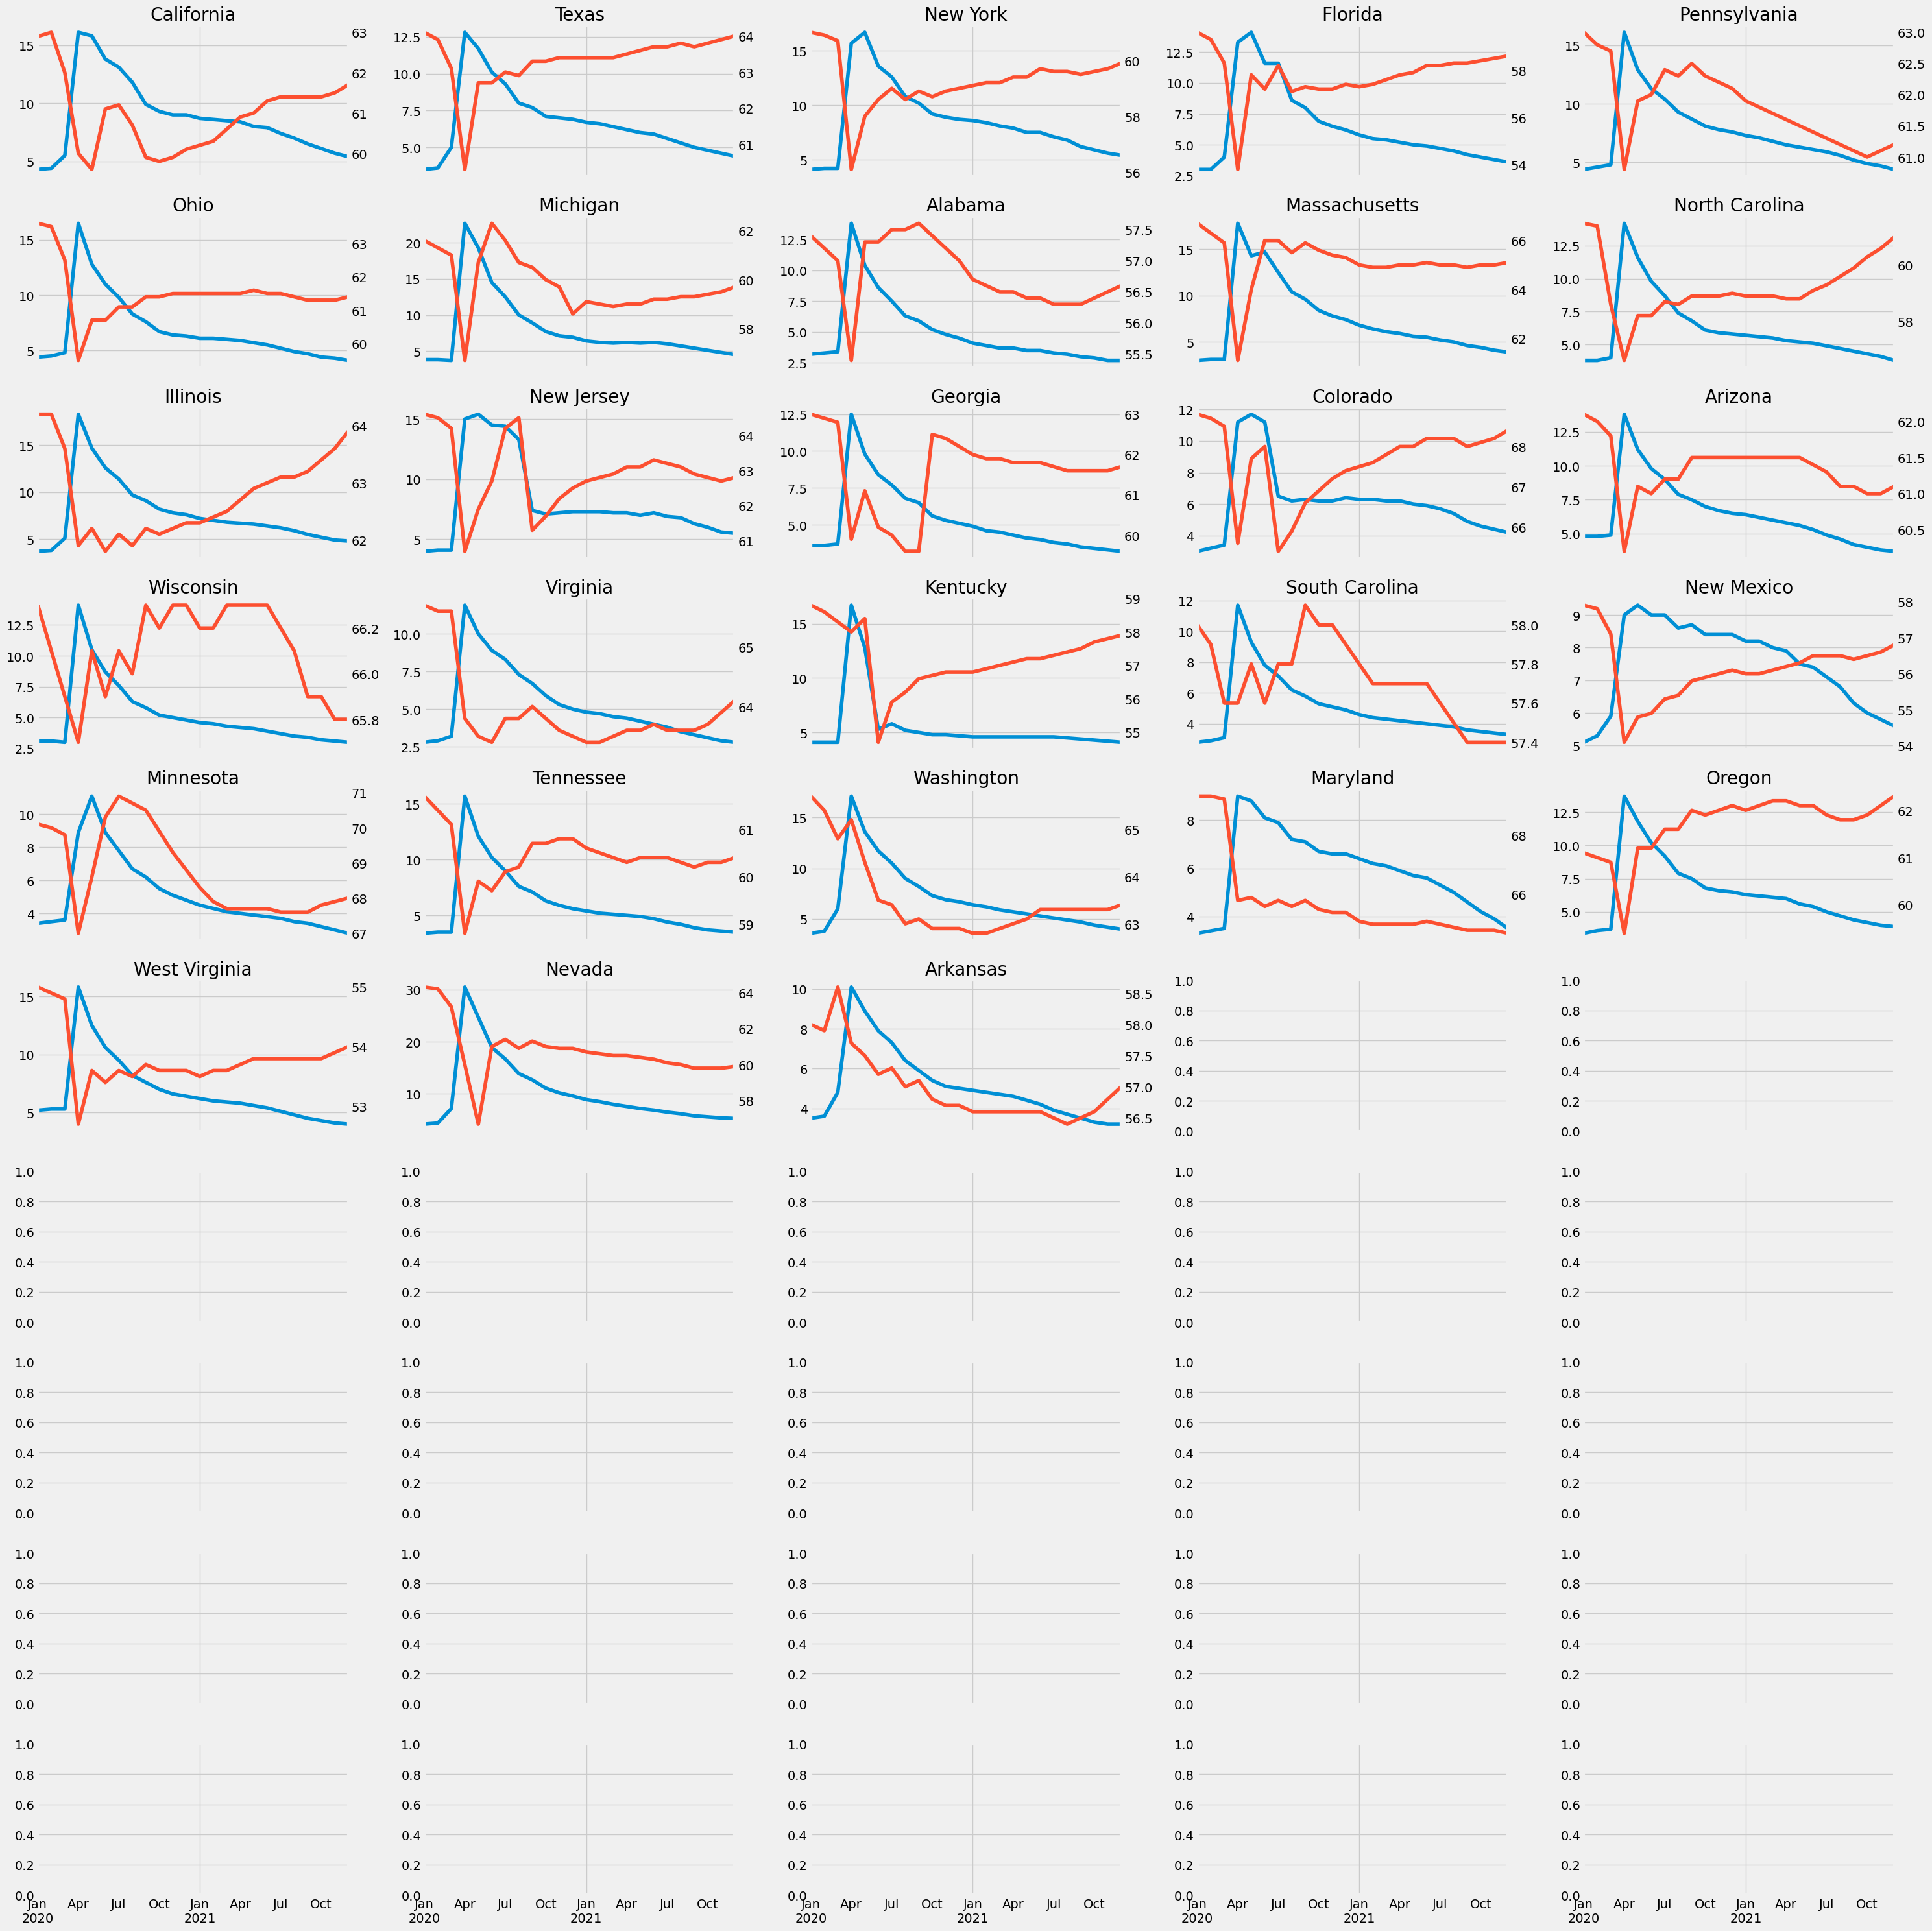

In [39]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

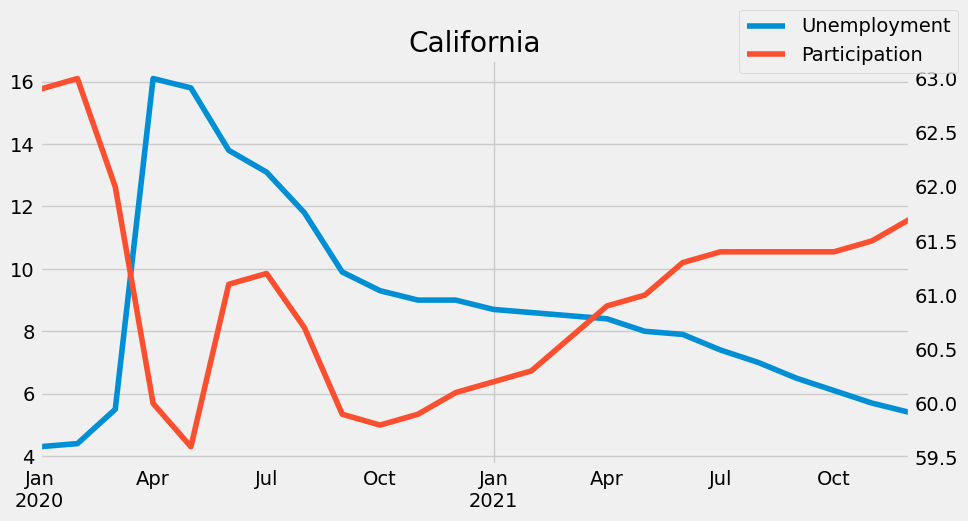

In [18]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()